# Creando estructura YOLO

In [ ]:
def convert_yolo(box, size=(117, 926)):
    dw = 1./size[1]
    dh = 1./size[0]
    x = (box[0] + box[2])/2.0
    y = (box[1] + box[3])/2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [ ]:
import os,shutil
import json
from pathlib import Path
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!unzip /content/drive/MyDrive/DatasetMusica/dataset.zip

In [ ]:
%mkdir datasetYOLO
%mkdir datasetYOLO/train
%mkdir datasetYOLO/test

- Creando las imágenes

In [ ]:
carpetas=['train/','test/']
path_o='dataset/'
path_t='datasetYOLO/'
for dir in carpetas:
  for file in os.listdir(path_o+dir+'images'):
    original = path_o+dir
    target = path_t+dir
    stem=Path(file).stem
    shutil.move(original+'images/'+file,target+file)

- Creando las anotaciones

In [ ]:
d={'claved':0, 'claves':1, 'clavef':2, 'nota1':3, 'nota2':4, 'nota4':5, 'nota1:2':6, 'nota1:4':7, 'notae':8, 'sos':9, 'bem':10, 'bec':11, 'sil0':12, 'sil1':13, 'sil2':14, 'sil1:2':15, 'sil1:4':16, '2x4':17, '3x4':18, '4x4':19, '6x8':20, 'punt':21, 'liga':22,'3':23,'line':24,'P2':25, 'nota1:8':26, 'cal':27, '3x2':28,'mf':29,'P1':30,'check':31,'3x8':32,'2x2':33}
carpetas=['train/','test/']
path_o='dataset/'
path_t='datasetYOLO/'
for dir in carpetas:
  for file in os.listdir(path_o+dir+'annotations'):
    original = path_o+dir
    target = path_t+dir
    a = json.load(open(original+'annotations/'+file))
    b = open(target+file[:-4]+'txt','w')
    for coords in a:
      x,y,w,h = convert_yolo(coords['box'])
      label = d[coords['label']]
      b.write(str(label) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + '\n')
    b.close()

- Creando el train.txt y test.txt

In [ ]:
image_files = []
os.chdir(os.path.join("datasetYOLO","test"))
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".jpg"):
        image_files.append("datasetYOLO/test/" + filename)
os.chdir("..")
with open("test.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()
os.chdir("..")

In [ ]:
image_files = []
os.chdir(os.path.join("datasetYOLO","train"))
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".jpg"):
        image_files.append("datasetYOLO/train/" + filename)
os.chdir("..")
with open("train.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()
os.chdir("..")

- Creando el classes.names

In [ ]:
d = {a:b for b,a in d.items()}
with open('datasetYOLO/classes.txt','w') as f:
  for i in range(0,34):
    f.write(d[i]+'\n')

- Guardando en drive

In [ ]:
import shutil
shutil.make_archive('/content/datasetYOLO','zip','/content/datasetYOLO')

'/content/datasetYOLO.zip'

# Código mAP

In [40]:
import argparse
import statistics as stats

In [33]:
MINOVERLAP = 0.5 # default value (defined in the PASCAL VOC2012 challenge)

parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('-na', '--no-animation', help="no animation is shown.", action="store_true")
parser.add_argument('-np', '--no-plot', help="no plot is shown.", action="store_true")
parser.add_argument('-q', '--quiet', help="minimalistic console output.", action="store_true")
# argparse receiving list of classes to be ignored (e.g., python main.py --ignore person book)
parser.add_argument('-i', '--ignore', nargs='+', type=str, help="ignore a list of classes.")
# # argparse receiving list of classes with specific IoU (e.g., python main.py --set-class-iou person 0.7)
parser.add_argument('--set-class-iou', nargs='+', type=str, help="set IoU for a specific class.")

args = parser.parse_args()

In [34]:
def log_average_miss_rate(prec, rec, num_images):
    """
        log-average miss rate:
            Calculated by averaging miss rates at 9 evenly spaced FPPI points
            between 10e-2 and 10e0, in log-space.
        output:
                lamr | log-average miss rate
                mr | miss rate
                fppi | false positives per image
        references:
            [1] Dollar, Piotr, et al. "Pedestrian Detection: An Evaluation of the
               State of the Art." Pattern Analysis and Machine Intelligence, IEEE
               Transactions on 34.4 (2012): 743 - 761.
    """

    # if there were no detections of that class
    if prec.size == 0:
        lamr = 0
        mr = 1
        fppi = 0
        return lamr, mr, fppi

    fppi = (1 - prec)
    mr = (1 - rec)

    fppi_tmp = np.insert(fppi, 0, -1.0)
    mr_tmp = np.insert(mr, 0, 1.0)

    # Use 9 evenly spaced reference points in log-space
    ref = np.logspace(-2.0, 0.0, num = 9)
    for i, ref_i in enumerate(ref):
        # np.where() will always find at least 1 index, since min(ref) = 0.01 and min(fppi_tmp) = -1.0
        j = np.where(fppi_tmp <= ref_i)[-1][-1]
        ref[i] = mr_tmp[j]

    # log(0) is undefined, so we use the np.maximum(1e-10, ref)
    lamr = math.exp(np.mean(np.log(np.maximum(1e-10, ref))))

    return lamr, mr, fppi

"""
 throw error and exit
"""
def error(msg):
    print(msg)
    sys.exit(0)

"""
 check if the number is a float between 0.0 and 1.0
"""
def is_float_between_0_and_1(value):
    try:
        val = float(value)
        if val > 0.0 and val < 1.0:
            return True
        else:
            return False
    except ValueError:
        return False

"""
 Calculate the AP given the recall and precision array
    1st) We compute a version of the measured precision/recall curve with
         precision monotonically decreasing
    2nd) We compute the AP as the area under this curve by numerical integration.
"""
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


"""
 Convert the lines of a file to a list
"""
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    return content

"""
 Draws text in image
"""
def draw_text_in_image(img, text, pos, color, line_width):
    font = cv2.FONT_HERSHEY_PLAIN
    fontScale = 1
    lineType = 1
    bottomLeftCornerOfText = pos
    cv2.putText(img, text,
            bottomLeftCornerOfText,
            font,
            fontScale,
            color,
            lineType)
    text_width, _ = cv2.getTextSize(text, font, fontScale, lineType)[0]
    return img, (line_width + text_width)

"""
 Plot - adjust axes
"""
def adjust_axes(r, t, fig, axes):
    # get text width for re-scaling
    bb = t.get_window_extent(renderer=r)
    text_width_inches = bb.width / fig.dpi
    # get axis width in inches
    current_fig_width = fig.get_figwidth()
    new_fig_width = current_fig_width + text_width_inches
    propotion = new_fig_width / current_fig_width
    # get axis limit
    x_lim = axes.get_xlim()
    axes.set_xlim([x_lim[0], x_lim[1]*propotion])

"""
 Draw plot using Matplotlib
"""
def draw_plot_func(dictionary, n_classes, window_title, plot_title, x_label, output_path, to_show, plot_color, true_p_bar):
    # sort the dictionary by decreasing value, into a list of tuples
    sorted_dic_by_value = sorted(dictionary.items(), key=operator.itemgetter(1))
    # unpacking the list of tuples into two lists
    sorted_keys, sorted_values = zip(*sorted_dic_by_value)
    # 
    if true_p_bar != "":
        """
         Special case to draw in:
            - green -> TP: True Positives (object detected and matches ground-truth)
            - red -> FP: False Positives (object detected but does not match ground-truth)
            - pink -> FN: False Negatives (object not detected but present in the ground-truth)
        """
        fp_sorted = []
        tp_sorted = []
        for key in sorted_keys:
            fp_sorted.append(dictionary[key] - true_p_bar[key])
            tp_sorted.append(true_p_bar[key])
        plt.barh(range(n_classes), fp_sorted, align='center', color='crimson', label='False Positive')
        plt.barh(range(n_classes), tp_sorted, align='center', color='forestgreen', label='True Positive', left=fp_sorted)
        # add legend
        plt.legend(loc='lower right')
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            fp_val = fp_sorted[i]
            tp_val = tp_sorted[i]
            fp_str_val = " " + str(fp_val)
            tp_str_val = fp_str_val + " " + str(tp_val)
            # trick to paint multicolor with offset:
            # first paint everything and then repaint the first number
            t = plt.text(val, i, tp_str_val, color='forestgreen', va='center', fontweight='bold')
            plt.text(val, i, fp_str_val, color='crimson', va='center', fontweight='bold')
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    else:
        plt.barh(range(n_classes), sorted_values, color=plot_color)
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            str_val = " " + str(val) # add a space before
            if val < 1.0:
                str_val = " {0:.2f}".format(val)
            t = plt.text(val, i, str_val, color=plot_color, va='center', fontweight='bold')
            # re-set axes to show number inside the figure
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    # set window title
    fig.canvas.set_window_title(window_title)
    # write classes in y axis
    tick_font_size = 12
    plt.yticks(range(n_classes), sorted_keys, fontsize=tick_font_size)
    """
     Re-scale height accordingly
    """
    init_height = fig.get_figheight()
    # comput the matrix height in points and inches
    dpi = fig.dpi
    height_pt = n_classes * (tick_font_size * 1.4) # 1.4 (some spacing)
    height_in = height_pt / dpi
    # compute the required figure height 
    top_margin = 0.15 # in percentage of the figure height
    bottom_margin = 0.05 # in percentage of the figure height
    figure_height = height_in / (1 - top_margin - bottom_margin)
    # set new height
    if figure_height > init_height:
        fig.set_figheight(figure_height)

    # set plot title
    plt.title(plot_title, fontsize=14)
    # set axis titles
    # plt.xlabel('classes')
    plt.xlabel(x_label, fontsize='large')
    # adjust size of window
    fig.tight_layout()
    # save the plot
    fig.savefig(output_path)
    # show image
    if to_show:
        plt.show()
    # close the plot
    plt.close()

In [35]:
def mAP():
  # if there are no classes to ignore then replace None by empty list
  if args.ignore is None:
      args.ignore = []

  specific_iou_flagged = False
  if args.set_class_iou is not None:
      specific_iou_flagged = True

  # make sure that the cwd() is the location of the python script (so that every path makes sense)
  #os.chdir(os.path.dirname(os.path.abspath(__file__)))

  GT_PATH = os.path.join(os.getcwd(), 'input', 'ground-truth')
  DR_PATH = os.path.join(os.getcwd(), 'input', 'detection-results')
  # if there are no images then no animation can be shown
  IMG_PATH = os.path.join(os.getcwd(), 'input', 'images-optional')
  if os.path.exists(IMG_PATH): 
      for dirpath, dirnames, files in os.walk(IMG_PATH):
          if not files:
              # no image files found
              args.no_animation = True
  else:
      args.no_animation = True

  # try to import OpenCV if the user didn't choose the option --no-animation
  show_animation = False
  if not args.no_animation:
      try:
          import cv2
          show_animation = True
      except ImportError:
          print("\"opencv-python\" not found, please install to visualize the results.")
          args.no_animation = True

  # try to import Matplotlib if the user didn't choose the option --no-plot
  draw_plot = False
  if not args.no_plot:
      try:
          import matplotlib.pyplot as plt
          draw_plot = True
      except ImportError:
          print("\"matplotlib\" not found, please install it to get the resulting plots.")
          args.no_plot = True



  """
  Create a ".temp_files/" and "output/" directory
  """
  TEMP_FILES_PATH = ".temp_files"
  if not os.path.exists(TEMP_FILES_PATH): # if it doesn't exist already
      os.makedirs(TEMP_FILES_PATH)
  output_files_path = "output"
  if os.path.exists(output_files_path): # if it exist already
      # reset the output directory
      shutil.rmtree(output_files_path)

  os.makedirs(output_files_path)
  if draw_plot:
      os.makedirs(os.path.join(output_files_path, "classes"))
  if show_animation:
      os.makedirs(os.path.join(output_files_path, "images", "detections_one_by_one"))

  """
  ground-truth
      Load each of the ground-truth files into a temporary ".json" file.
      Create a list of all the class names present in the ground-truth (gt_classes).
  """
  # get a list with the ground-truth files
  ground_truth_files_list = glob.glob(GT_PATH + '/*.txt')
  if len(ground_truth_files_list) == 0:
      error("Error: No ground-truth files found!")
  ground_truth_files_list.sort()
  # dictionary with counter per class
  gt_counter_per_class = {}
  counter_images_per_class = {}

  gt_files = []
  for txt_file in ground_truth_files_list:
      #print(txt_file)
      file_id = txt_file.split(".txt", 1)[0]
      file_id = os.path.basename(os.path.normpath(file_id))
      # check if there is a correspondent detection-results file
      temp_path = os.path.join(DR_PATH, (file_id + ".txt"))
      if not os.path.exists(temp_path):
          error_msg = "Error. File not found: {}\n".format(temp_path)
          error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
          error(error_msg)
      lines_list = file_lines_to_list(txt_file)
      # create ground-truth dictionary
      bounding_boxes = []
      is_difficult = False
      already_seen_classes = []
      for line in lines_list:
          try:
              if "difficult" in line:
                      class_name, left, top, right, bottom, _difficult = line.split()
                      is_difficult = True
              else:
                      class_name, left, top, right, bottom = line.split()
          except ValueError:
              error_msg = "Error: File " + txt_file + " in the wrong format.\n"
              error_msg += " Expected: <class_name> <left> <top> <right> <bottom> ['difficult']\n"
              error_msg += " Received: " + line
              error_msg += "\n\nIf you have a <class_name> with spaces between words you should remove them\n"
              error_msg += "by running the script \"remove_space.py\" or \"rename_class.py\" in the \"extra/\" folder."
              error(error_msg)
          # check if class is in the ignore list, if yes skip
          if class_name in args.ignore:
              continue
          bbox = left + " " + top + " " + right + " " +bottom
          if is_difficult:
              bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False, "difficult":True})
              is_difficult = False
          else:
              bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False})
              # count that object
              if class_name in gt_counter_per_class:
                  gt_counter_per_class[class_name] += 1
              else:
                  # if class didn't exist yet
                  gt_counter_per_class[class_name] = 1

              if class_name not in already_seen_classes:
                  if class_name in counter_images_per_class:
                      counter_images_per_class[class_name] += 1
                  else:
                      # if class didn't exist yet
                      counter_images_per_class[class_name] = 1
                  already_seen_classes.append(class_name)


      # dump bounding_boxes into a ".json" file
      new_temp_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
      gt_files.append(new_temp_file)
      with open(new_temp_file, 'w') as outfile:
          json.dump(bounding_boxes, outfile)

  gt_classes = list(gt_counter_per_class.keys())
  # let's sort the classes alphabetically
  gt_classes = sorted(gt_classes)
  n_classes = len(gt_classes)
  #print(gt_classes)
  #print(gt_counter_per_class)

  """
  Check format of the flag --set-class-iou (if used)
      e.g. check if class exists
  """
  if specific_iou_flagged:
      n_args = len(args.set_class_iou)
      error_msg = \
          '\n --set-class-iou [class_1] [IoU_1] [class_2] [IoU_2] [...]'
      if n_args % 2 != 0:
          error('Error, missing arguments. Flag usage:' + error_msg)
      # [class_1] [IoU_1] [class_2] [IoU_2]
      # specific_iou_classes = ['class_1', 'class_2']
      specific_iou_classes = args.set_class_iou[::2] # even
      # iou_list = ['IoU_1', 'IoU_2']
      iou_list = args.set_class_iou[1::2] # odd
      if len(specific_iou_classes) != len(iou_list):
          error('Error, missing arguments. Flag usage:' + error_msg)
      for tmp_class in specific_iou_classes:
          if tmp_class not in gt_classes:
                      error('Error, unknown class \"' + tmp_class + '\". Flag usage:' + error_msg)
      for num in iou_list:
          if not is_float_between_0_and_1(num):
              error('Error, IoU must be between 0.0 and 1.0. Flag usage:' + error_msg)

  """
  detection-results
      Load each of the detection-results files into a temporary ".json" file.
  """
  # get a list with the detection-results files
  dr_files_list = glob.glob(DR_PATH + '/*.txt')
  dr_files_list.sort()

  for class_index, class_name in enumerate(gt_classes):
      bounding_boxes = []
      for txt_file in dr_files_list:
          #print(txt_file)
          # the first time it checks if all the corresponding ground-truth files exist
          file_id = txt_file.split(".txt",1)[0]
          file_id = os.path.basename(os.path.normpath(file_id))
          temp_path = os.path.join(GT_PATH, (file_id + ".txt"))
          if class_index == 0:
              if not os.path.exists(temp_path):
                  error_msg = "Error. File not found: {}\n".format(temp_path)
                  error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
                  error(error_msg)
          lines = file_lines_to_list(txt_file)
          for line in lines:
              try:
                  tmp_class_name, confidence, left, top, right, bottom = line.split()
              except ValueError:
                  error_msg = "Error: File " + txt_file + " in the wrong format.\n"
                  error_msg += " Expected: <class_name> <confidence> <left> <top> <right> <bottom>\n"
                  error_msg += " Received: " + line
                  error(error_msg)
              if tmp_class_name == class_name:
                  #print("match")
                  bbox = left + " " + top + " " + right + " " +bottom
                  bounding_boxes.append({"confidence":confidence, "file_id":file_id, "bbox":bbox})
                  #print(bounding_boxes)
      # sort detection-results by decreasing confidence
      bounding_boxes.sort(key=lambda x:float(x['confidence']), reverse=True)
      with open(TEMP_FILES_PATH + "/" + class_name + "_dr.json", 'w') as outfile:
          json.dump(bounding_boxes, outfile)

  """
  Calculate the AP for each class
  """
  sum_AP = 0.0
  ap_dictionary = {}
  lamr_dictionary = {}
  # open file to store the output
  with open(output_files_path + "/output.txt", 'w') as output_file:
      output_file.write("# AP and precision/recall per class\n")
      count_true_positives = {}
      for class_index, class_name in enumerate(gt_classes):
          count_true_positives[class_name] = 0
          """
          Load detection-results of that class
          """
          dr_file = TEMP_FILES_PATH + "/" + class_name + "_dr.json"
          dr_data = json.load(open(dr_file))

          """
          Assign detection-results to ground-truth objects
          """
          nd = len(dr_data)
          tp = [0] * nd # creates an array of zeros of size nd
          fp = [0] * nd
          for idx, detection in enumerate(dr_data):
              file_id = detection["file_id"]
              if show_animation:
                  # find ground truth image
                  ground_truth_img = glob.glob1(IMG_PATH, file_id + ".*")
                  #tifCounter = len(glob.glob1(myPath,"*.tif"))
                  if len(ground_truth_img) == 0:
                      error("Error. Image not found with id: " + file_id)
                  elif len(ground_truth_img) > 1:
                      error("Error. Multiple image with id: " + file_id)
                  else: # found image
                      #print(IMG_PATH + "/" + ground_truth_img[0])
                      # Load image
                      img = cv2.imread(IMG_PATH + "/" + ground_truth_img[0])
                      # load image with draws of multiple detections
                      img_cumulative_path = output_files_path + "/images/" + ground_truth_img[0]
                      if os.path.isfile(img_cumulative_path):
                          img_cumulative = cv2.imread(img_cumulative_path)
                      else:
                          img_cumulative = img.copy()
                      # Add bottom border to image
                      bottom_border = 60
                      BLACK = [0, 0, 0]
                      img = cv2.copyMakeBorder(img, 0, bottom_border, 0, 0, cv2.BORDER_CONSTANT, value=BLACK)
              # assign detection-results to ground truth object if any
              # open ground-truth with that file_id
              gt_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
              ground_truth_data = json.load(open(gt_file))
              ovmax = -1
              gt_match = -1
              # load detected object bounding-box
              bb = [ float(x) for x in detection["bbox"].split() ]
              for obj in ground_truth_data:
                  # look for a class_name match
                  if obj["class_name"] == class_name:
                      bbgt = [ float(x) for x in obj["bbox"].split() ]
                      bi = [max(bb[0],bbgt[0]), max(bb[1],bbgt[1]), min(bb[2],bbgt[2]), min(bb[3],bbgt[3])]
                      iw = bi[2] - bi[0] + 1
                      ih = bi[3] - bi[1] + 1
                      if iw > 0 and ih > 0:
                          # compute overlap (IoU) = area of intersection / area of union
                          ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                                          + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                          ov = iw * ih / ua
                          if ov > ovmax:
                              ovmax = ov
                              gt_match = obj

              # assign detection as true positive/don't care/false positive
              if show_animation:
                  status = "NO MATCH FOUND!" # status is only used in the animation
              # set minimum overlap
              min_overlap = MINOVERLAP
              if specific_iou_flagged:
                  if class_name in specific_iou_classes:
                      index = specific_iou_classes.index(class_name)
                      min_overlap = float(iou_list[index])
              if ovmax >= min_overlap:
                  if "difficult" not in gt_match:
                          if not bool(gt_match["used"]):
                              # true positive
                              tp[idx] = 1
                              gt_match["used"] = True
                              count_true_positives[class_name] += 1
                              # update the ".json" file
                              with open(gt_file, 'w') as f:
                                      f.write(json.dumps(ground_truth_data))
                              if show_animation:
                                  status = "MATCH!"
                          else:
                              # false positive (multiple detection)
                              fp[idx] = 1
                              if show_animation:
                                  status = "REPEATED MATCH!"
              else:
                  # false positive
                  fp[idx] = 1
                  if ovmax > 0:
                      status = "INSUFFICIENT OVERLAP"

              """
              Draw image to show animation
              """
              if show_animation:
                  height, widht = img.shape[:2]
                  # colors (OpenCV works with BGR)
                  white = (255,255,255)
                  light_blue = (255,200,100)
                  green = (0,255,0)
                  light_red = (30,30,255)
                  # 1st line
                  margin = 10
                  v_pos = int(height - margin - (bottom_border / 2.0))
                  text = "Image: " + ground_truth_img[0] + " "
                  img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                  text = "Class [" + str(class_index) + "/" + str(n_classes) + "]: " + class_name + " "
                  img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), light_blue, line_width)
                  if ovmax != -1:
                      color = light_red
                      if status == "INSUFFICIENT OVERLAP":
                          text = "IoU: {0:.2f}% ".format(ovmax*100) + "< {0:.2f}% ".format(min_overlap*100)
                      else:
                          text = "IoU: {0:.2f}% ".format(ovmax*100) + ">= {0:.2f}% ".format(min_overlap*100)
                          color = green
                      img, _ = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)
                  # 2nd line
                  v_pos += int(bottom_border / 2.0)
                  rank_pos = str(idx+1) # rank position (idx starts at 0)
                  text = "Detection #rank: " + rank_pos + " confidence: {0:.2f}% ".format(float(detection["confidence"])*100)
                  img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                  color = light_red
                  if status == "MATCH!":
                      color = green
                  text = "Result: " + status + " "
                  img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)

                  font = cv2.FONT_HERSHEY_SIMPLEX
                  if ovmax > 0: # if there is intersections between the bounding-boxes
                      bbgt = [ int(round(float(x))) for x in gt_match["bbox"].split() ]
                      cv2.rectangle(img,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                      cv2.rectangle(img_cumulative,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                      cv2.putText(img_cumulative, class_name, (bbgt[0],bbgt[1] - 5), font, 0.6, light_blue, 1, cv2.LINE_AA)
                  bb = [int(i) for i in bb]
                  cv2.rectangle(img,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                  cv2.rectangle(img_cumulative,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                  cv2.putText(img_cumulative, class_name, (bb[0],bb[1] - 5), font, 0.6, color, 1, cv2.LINE_AA)
                  # show image
                  cv2.imshow("Animation", img)
                  cv2.waitKey(20) # show for 20 ms
                  # save image to output
                  output_img_path = output_files_path + "/images/detections_one_by_one/" + class_name + "_detection" + str(idx) + ".jpg"
                  cv2.imwrite(output_img_path, img)
                  # save the image with all the objects drawn to it
                  cv2.imwrite(img_cumulative_path, img_cumulative)

          #print(tp)
          # compute precision/recall
          cumsum = 0
          for idx, val in enumerate(fp):
              fp[idx] += cumsum
              cumsum += val
          cumsum = 0
          for idx, val in enumerate(tp):
              tp[idx] += cumsum
              cumsum += val
          #print(tp)
          rec = tp[:]
          for idx, val in enumerate(tp):
              rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
          #print(rec)
          prec = tp[:]
          for idx, val in enumerate(tp):
              prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])
          #print(prec)

          ap, mrec, mprec = voc_ap(rec[:], prec[:])
          sum_AP += ap
          text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)
          """
          Write to output.txt
          """
          rounded_prec = [ '%.2f' % elem for elem in prec ]
          rounded_rec = [ '%.2f' % elem for elem in rec ]
          output_file.write(text + "\n Precision: " + str(rounded_prec) + "\n Recall :" + str(rounded_rec) + "\n\n")
          if not args.quiet:
              print(text)
          ap_dictionary[class_name] = ap

          n_images = counter_images_per_class[class_name]
          lamr, mr, fppi = log_average_miss_rate(np.array(prec), np.array(rec), n_images)
          lamr_dictionary[class_name] = lamr

          """
          Draw plot
          """
          if draw_plot:
              plt.plot(rec, prec, '-o')
              # add a new penultimate point to the list (mrec[-2], 0.0)
              # since the last line segment (and respective area) do not affect the AP value
              area_under_curve_x = mrec[:-1] + [mrec[-2]] + [mrec[-1]]
              area_under_curve_y = mprec[:-1] + [0.0] + [mprec[-1]]
              plt.fill_between(area_under_curve_x, 0, area_under_curve_y, alpha=0.2, edgecolor='r')
              # set window title
              fig = plt.gcf() # gcf - get current figure
              fig.canvas.set_window_title('AP ' + class_name)
              # set plot title
              plt.title('class: ' + text)
              #plt.suptitle('This is a somewhat long figure title', fontsize=16)
              # set axis titles
              plt.xlabel('Recall')
              plt.ylabel('Precision')
              # optional - set axes
              axes = plt.gca() # gca - get current axes
              axes.set_xlim([0.0,1.0])
              axes.set_ylim([0.0,1.05]) # .05 to give some extra space
              # Alternative option -> wait for button to be pressed
              #while not plt.waitforbuttonpress(): pass # wait for key display
              # Alternative option -> normal display
              #plt.show()
              # save the plot
              fig.savefig(output_files_path + "/classes/" + class_name + ".png")
              plt.cla() # clear axes for next plot

      if show_animation:
          cv2.destroyAllWindows()

      output_file.write("\n# mAP of all classes\n")
      mAP = sum_AP / n_classes
      text = "mAP = {0:.2f}%".format(mAP*100)
      output_file.write(text + "\n")
      print(text)

  """
  Draw false negatives
  """
  if show_animation:
      pink = (203,192,255)
      for tmp_file in gt_files:
          ground_truth_data = json.load(open(tmp_file))
          #print(ground_truth_data)
          # get name of corresponding image
          start = TEMP_FILES_PATH + '/'
          img_id = tmp_file[tmp_file.find(start)+len(start):tmp_file.rfind('_ground_truth.json')]
          img_cumulative_path = output_files_path + "/images/" + img_id + ".jpg"
          img = cv2.imread(img_cumulative_path)
          if img is None:
              img_path = IMG_PATH + '/' + img_id + ".jpg"
              img = cv2.imread(img_path)
          # draw false negatives
          for obj in ground_truth_data:
              if not obj['used']:
                  bbgt = [ int(round(float(x))) for x in obj["bbox"].split() ]
                  cv2.rectangle(img,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),pink,2)
          cv2.imwrite(img_cumulative_path, img)

  # remove the temp_files directory
  shutil.rmtree(TEMP_FILES_PATH)

  """
  Count total of detection-results
  """
  # iterate through all the files
  det_counter_per_class = {}
  for txt_file in dr_files_list:
      # get lines to list
      lines_list = file_lines_to_list(txt_file)
      for line in lines_list:
          class_name = line.split()[0]
          # check if class is in the ignore list, if yes skip
          if class_name in args.ignore:
              continue
          # count that object
          if class_name in det_counter_per_class:
              det_counter_per_class[class_name] += 1
          else:
              # if class didn't exist yet
              det_counter_per_class[class_name] = 1
  #print(det_counter_per_class)
  dr_classes = list(det_counter_per_class.keys())


  """
  Plot the total number of occurences of each class in the ground-truth
  """
  if draw_plot:
      window_title = "ground-truth-info"
      plot_title = "ground-truth\n"
      plot_title += "(" + str(len(ground_truth_files_list)) + " files and " + str(n_classes) + " classes)"
      x_label = "Number of objects per class"
      output_path = output_files_path + "/ground-truth-info.png"
      to_show = False
      plot_color = 'forestgreen'
      draw_plot_func(
          gt_counter_per_class,
          n_classes,
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          '',
          )

  """
  Write number of ground-truth objects per class to results.txt
  """
  with open(output_files_path + "/output.txt", 'a') as output_file:
      output_file.write("\n# Number of ground-truth objects per class\n")
      for class_name in sorted(gt_counter_per_class):
          output_file.write(class_name + ": " + str(gt_counter_per_class[class_name]) + "\n")

  """
  Finish counting true positives
  """
  for class_name in dr_classes:
      # if class exists in detection-result but not in ground-truth then there are no true positives in that class
      if class_name not in gt_classes:
          count_true_positives[class_name] = 0
  #print(count_true_positives)

  """
  Plot the total number of occurences of each class in the "detection-results" folder
  """
  if draw_plot:
      window_title = "detection-results-info"
      # Plot title
      plot_title = "detection-results\n"
      plot_title += "(" + str(len(dr_files_list)) + " files and "
      count_non_zero_values_in_dictionary = sum(int(x) > 0 for x in list(det_counter_per_class.values()))
      plot_title += str(count_non_zero_values_in_dictionary) + " detected classes)"
      # end Plot title
      x_label = "Number of objects per class"
      output_path = output_files_path + "/detection-results-info.png"
      to_show = False
      plot_color = 'forestgreen'
      true_p_bar = count_true_positives
      draw_plot_func(
          det_counter_per_class,
          len(det_counter_per_class),
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          true_p_bar
          )

  """
  Write number of detected objects per class to output.txt
  """
  with open(output_files_path + "/output.txt", 'a') as output_file:
      output_file.write("\n# Number of detected objects per class\n")
      for class_name in sorted(dr_classes):
          n_det = det_counter_per_class[class_name]
          text = class_name + ": " + str(n_det)
          text += " (tp:" + str(count_true_positives[class_name]) + ""
          text += ", fp:" + str(n_det - count_true_positives[class_name]) + ")\n"
          output_file.write(text)

  """
  Draw log-average miss rate plot (Show lamr of all classes in decreasing order)
  """
  if draw_plot:
      window_title = "lamr"
      plot_title = "log-average miss rate"
      x_label = "log-average miss rate"
      output_path = output_files_path + "/lamr.png"
      to_show = False
      plot_color = 'royalblue'
      draw_plot_func(
          lamr_dictionary,
          n_classes,
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          ""
          )

  """
  Draw mAP plot (Show AP's of all classes in decreasing order)
  """
  if draw_plot:
      window_title = "mAP"
      plot_title = "mAP = {0:.2f}%".format(mAP*100)
      x_label = "Average Precision"
      output_path = output_files_path + "/mAP.png"
      to_show = False
      plot_color = 'royalblue'
      draw_plot_func(
          ap_dictionary,
          n_classes,
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          ""
          )
  return sum_AP*100

# Funcionalidades

- Librería

In [1]:
%%capture
!git clone https://github.com/AlexeyAB/darknet
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!/usr/local/cuda/bin/nvcc --version
!make
!apt-get install tree

In [2]:
%%capture
!wget https://www.dropbox.com/s/82mtx7r0jobjfru/datasetYOLO.zip?dl=1 -O datasetYOLO.zip
!unzip datasetYOLO.zip

- Descargamos pesos preentrenados

In [3]:
%%capture
!wget https://www.dropbox.com/s/9p53walw9h2j0ws/train_last.weights?dl=1 -O train_last.weights

In [4]:
!tree datasetYOLO -L 1 -C

datasetYOLO
├── classes.data
├── classes.names
├── test
├── test.txt
├── train
├── train.cfg
└── train.txt

2 directories, 5 files


In [18]:
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

def mostrarImagen(imagePath):
  image = cv2.imread(imagePath)
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    fig, ax = plt.subplots(1,1,figsize=(16,5))
    ax.imshow(img2,cmap=plt.cm.binary)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.axis('off')
    plt.show()
  else:
    img2 = image
    fig, ax = plt.subplots(1,1,figsize=(16,5))
    ax.imshow(img2,cmap=plt.cm.binary)
    ax.axis('off')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.show()

def mostrarImagenConAnotacion(imagePath,annotationPath,classesPath):
    image = cv2.imread(imagePath)
    (H,W)=image.shape[:2]
    with open(annotationPath) as f:
        lines = f.readlines()
    with open(classesPath) as f:
        clases = f.readlines()
    for annot in lines:
        (c,x,y,w,h) = annot.split(' ')
        cv2.rectangle(image,(int((float(x)-float(w)/2)*W),int((float(y)-float(h)/2)*H)),(int((float(x)+float(w)/2)*W),int((float(y)+float(h)/2)*H)),(0,255,0),1)
        cv2.putText(image,clases[int(c)],(int((float(x)-float(w)/2)*W),int((float(y)-float(h)/2)*H-2)),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,0),1)
    img2 = image[:,:,::-1]
    fig, ax = plt.subplots(1,1,figsize=(16,5))
    ax.imshow(img2,cmap=plt.cm.binary)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.axis('off')
    plt.show()

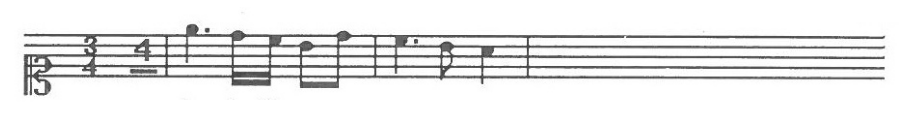

In [19]:
mostrarImagen('datasetYOLO/train/pent1001.jpg')

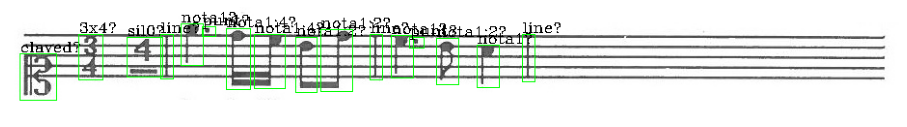

In [20]:
mostrarImagenConAnotacion('datasetYOLO/train/pent1001.jpg','datasetYOLO/train/pent1001.txt','datasetYOLO/classes.names')

In [8]:
!cat /content/datasetYOLO/classes.names

cat: /content/datasetYOLO/classes.names: No such file or directory


In [9]:
!cat datasetYOLO/classes.data

classes = 34
train  = datasetYOLO/train.txt
valid  = datasetYOLO/test.txt
names = datasetYOLO/classes.names
backup = backup

- Para entrenar (hecho desde Simba)

In [ ]:
%%capture
#!./darknet detector train celldataset/classes.data celldataset/train.cfg yolov4.conv.137 -dont_show

## Predicción

In [21]:
%%capture
!./darknet detector test datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights datasetYOLO/train/pent1001.jpg -thresh 0.5

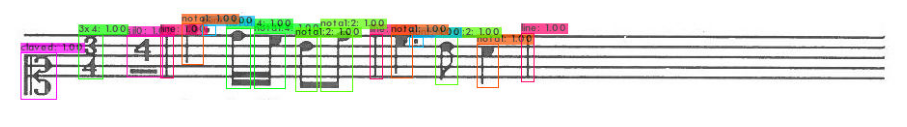

In [22]:
mostrarImagen('predictions.jpg')

In [23]:
%%capture
!./darknet detector test datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights datasetYOLO/train/pent2150.jpg -thresh 0.5

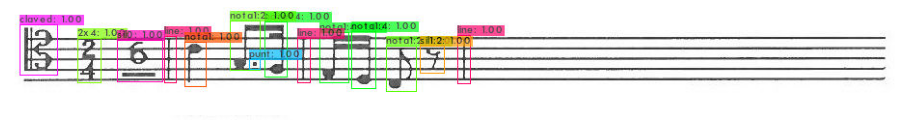

In [24]:
mostrarImagen('predictions.jpg')

In [32]:
%%capture
!./darknet detector test 'datasetYOLO/classes.data' 'datasetYOLO/train.cfg' 'train_last.weights' 'datasetYOLO/test/pent487.jpg' -thresh 0.5

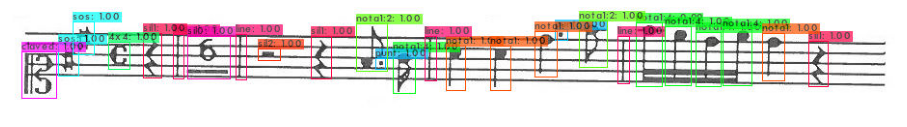

In [33]:
mostrarImagen('predictions.jpg')

- sacar el formato bboxs, labels, scores

In [36]:
%%capture
!./darknet detector test datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -ext_output -dont_show -out result.json < datasetYOLO/test.txt

## Métricas

- Para calcular precisón, recall... Nos fijamos solo en las métricas del IoU 0.5. Para el COCO metric hacemos la media del mAP para cada IoU.

In [16]:
!./darknet detector map datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -iou_thresh 0.50 -points 1000001
!./darknet detector map datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -iou_thresh 0.55 -points 1000001
!./darknet detector map datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -iou_thresh 0.60 -points 1000001
!./darknet detector map datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -iou_thresh 0.65 -points 1000001
!./darknet detector map datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -iou_thresh 0.70 -points 1000001
!./darknet detector map datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -iou_thresh 0.75 -points 1000001
!./darknet detector map datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -iou_thresh 0.80 -points 1000001
!./darknet detector map datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -iou_thresh 0.85 -points 1000001
!./darknet detector map datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -iou_thresh 0.90 -points 1000001
!./darknet detector map datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -iou_thresh 0.95 -points 1000001

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv  

In [17]:
(0.003461+0.124020+0.285824+0.516049+0.590110+0.619271+0.668013+0.678054+0.682533+0.682533)/10

0.4849868

Para un IoU de 0.5:
  - Precision = 0.89 
  - Recall = 0.90
  - F1-score = 0.90
  - mAP = 68.18 %

COCO-metric = 0.4844596

### Otra forma

In [45]:
%%capture
!wget https://www.dropbox.com/s/gm1a2jwipgqaht3/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

In [6]:
%mkdir 'input'
%mkdir 'input/ground-truth'
%mkdir 'input/detection-results'

In [25]:
path=Path('darknet/dataset/test')
files = get_files(path, folders = ['images'])

In [26]:
path_anot=path / 'annotations'
for f in files:
  n=f.stem+'.json'
  anotacion= json.loads(open(str(path_anot/n)).read())
  txt=open('input/ground-truth/'+f.stem+'.txt','w')
  for elemento in anotacion:
    label=elemento['label']
    x, y, z, w=elemento["box"]
    txt.write(label + ' ' + str(x) + ' ' + str(y) + ' '+ str(z) + ' '+ str(w) +'\n')
  txt.close()

In [4]:
def unconvert(width, height, x, y, w, h):
    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)
    return ([xmin,ymin, xmax,  ymax])

In [37]:
resultado=json.loads(open('darknet/result.json').read())
for res in resultado:
  txt=open('input/detection-results/'+Path(res['filename']).stem+'.txt','w')
  img=cv2.imread('darknet/'+res['filename'])
  height,width,_=img.shape
  for objeto in res['objects']:
    coords = objeto['relative_coordinates']
    conf = objeto['confidence']
    label = objeto['name']
    x,y,h,w=coords['center_x'],coords['center_y'],coords['height'],coords['width']
    xmin, xmax, ymin, ymax= unconvert(width, height, x, y, w, h)
    txt.write(label + ' ' +str(int(float(conf)*100)) + ' '+ str(xmin) + ' ' + str(xmax) + ' '+ str(ymin) + ' '+ str(ymax) +'\n')

In [38]:
mAP()

50.00% = 2x4 AP 
0.00% = 3 AP 
0.00% = 3x2 AP 
77.14% = 3x4 AP 
91.74% = 4x4 AP 
100.00% = 6x8 AP 
0.00% = P1 AP 
100.00% = bec AP 
94.00% = bem AP 
0.00% = check AP 
97.92% = claved AP 
100.00% = clavef AP 
92.33% = claves AP 
100.00% = liga AP 
89.13% = line AP 
83.13% = nota1 AP 
81.35% = nota1:2 AP 
100.00% = nota1:4 AP 
93.50% = nota2 AP 
97.00% = nota4 AP 
100.00% = notae AP 
100.00% = punt AP 
93.33% = sil0 AP 
85.71% = sil1 AP 
58.82% = sil1:2 AP 
100.00% = sil1:4 AP 
95.45% = sil2 AP 
87.10% = sos AP 
mAP = 77.42%


2167.6693845884693

In [42]:
txt=open('/content/output/output.txt','r')
linea=txt.readline()
gt={}
dt={}
while linea!= '# Number of ground-truth objects per class\n':
  linea=txt.readline()
  if 'mAP =' in linea: print(linea[:-1])
for i in range(0,28): # número de clases en test
  a = txt.readline().split()
  gt[a[0]]= a[1]    
txt.readline()
txt.readline()
a = txt.readline().split()
while a!= []:
  dt[a[0]]=a[1:]
  a = txt.readline().split()
n = len(dt.keys())
for key in gt.keys():
  if key not in dt.keys(): dt[key]=['0', '(tp:0,', 'fp:0)']

precision= np.sum([float(dt[i][1][4:-1])/(float(dt[i][1][4:-1])+float(dt[i][2][3:-1])) for i in dt if dt[i][1][4:-1] != '0'])/n
print('precision: ',precision)
recall=stats.mean([float(dt[i][1][4:-1])/float(gt[i])  for i in dt])
print('recall: ',recall)
f1 = (2*precision*recall)/(precision+recall)
print('f1 score: ',f1)
print('coco metric: ',0.4935895458422508)

mAP = 77.42%
precision:  0.8225944115245467
recall:  0.7846163791170454
f1 score:  0.8031566891044294
coco metric:  0.4935895458422508
